# Load Libraries

In [ ]:
# Load all necessary libraries
!pip install datasets

import torch
import numpy as np
from torch import nn
from transformers import GPT2Tokenizer, GPT2Config, GPT2Model, GPT2PreTrainedModel
from torch.optim import AdamW
from datasets import load_dataset
from tqdm import tqdm
from torch.nn import functional as F

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_built() else 'cpu'

dataset = load_dataset("gigant/ted_descriptions")
print(len(dataset['train']))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/5705 [00:00<?, ? examples/s]

5705


# Load Dataset

In [ ]:
print(dataset['train'][0])

{'url': 'https://www.ted.com/talks/jen_gunter_how_your_sense_of_smell_helps_you_savor_flavor', 'descr': "Eating pizza with a stuffy nose just isn't as satisfying -- and there's a reason for that. Dr. Jen Gunter explains how our ability to smell and taste work together to give us a full sensory experience. So whether you're sniffing the caramelized aroma of coffee, a whiff of trash or a trillion other things, your brain knows exactly what's under your nose. For more on how your body works, tune into her podcast, Body Stuff with Dr. Jen Gunter, from the TED Audio Collective."}


In [ ]:
text_corpus = [f"{txt} <|endoftext|>" for i, txt in enumerate(dataset['train']['descr']) if txt != '']
print(text_corpus[0])

Eating pizza with a stuffy nose just isn't as satisfying -- and there's a reason for that. Dr. Jen Gunter explains how our ability to smell and taste work together to give us a full sensory experience. So whether you're sniffing the caramelized aroma of coffee, a whiff of trash or a trillion other things, your brain knows exactly what's under your nose. For more on how your body works, tune into her podcast, Body Stuff with Dr. Jen Gunter, from the TED Audio Collective. <|endoftext|>


# Load Tokenizer

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', pad_token='<|pad|>')

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:
inp_text = "today is a beautiful day <|endoftext|><|endoftext|><|pad|><|pad|><|pad|>"

tokenized_inp_text = tokenizer(inp_text)['input_ids']
print(tokenized_inp_text)

[40838, 318, 257, 4950, 1110, 220, 50256, 50256, 50257, 50257, 50257]


In [ ]:
print(' '.join(tokenizer.convert_ids_to_tokens(tokenized_inp_text)))

today Ġis Ġa Ġbeautiful Ġday Ġ <|endoftext|> <|endoftext|> <|pad|> <|pad|> <|pad|>


# GPT-2 Model Architecture

In [ ]:
class GPT2_Model(GPT2PreTrainedModel):

    def __init__(self, config):

        super().__init__(config)

        self.transformer = GPT2Model.from_pretrained('gpt2')
        tokenizer = GPT2Tokenizer.from_pretrained('gpt2', pad_token='<|pad|>')

        # this is necessary since we add a new unique token for pad_token
        self.transformer.resize_token_embeddings(len(tokenizer))

        self.lm_head = nn.Linear(config.n_embd, len(tokenizer), bias=False)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):

        x = self.transformer(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)[0]
        x = self.lm_head(x)

        return x

# Training Dataloader

Text(0.5, 0, 'Token Length')

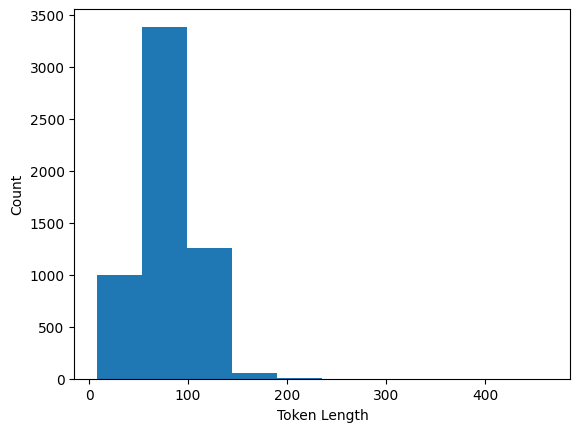

In [ ]:
tokenized_inp_len = [len(tokenizer(txt)['input_ids']) for txt in text_corpus]

np.random.seed(42)
x = np.asarray(tokenized_inp_len)

plt.hist(x, density=False, bins=10)
plt.ylabel('Count')
plt.xlabel('Token Length')

In [ ]:
class TedDataset(torch.utils.data.Dataset):

  def __init__(self, input_data, tokenizer, gpt2_type="gpt2", max_length=256):

    self.texts = [tokenizer(data, truncation=True, max_length=max_length, padding="max_length", return_tensors="pt")
                    for data in input_data]

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    return self.texts[idx]

# Loss Function

In [ ]:
class CrossEntropyLossFunction(nn.Module):

    def __init__(self):

        super(CrossEntropyLossFunction, self).__init__()
        self.loss_fct = nn.CrossEntropyLoss()

    def forward(self, lm_logits, labels):

        shift_logits = lm_logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()

        loss = self.loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

        return loss

# Model Fine-Tuning

In [ ]:
def train(model, tokenizer, train_data, epochs, learning_rate, epsilon=1e-8):

    train = TedDataset(train_data, tokenizer)
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)

    optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )
    criterion = CrossEntropyLossFunction().to(device)
    model = model.to(device)

    best_loss = 1000

    for epoch_i in range(0, epochs):

        total_train_loss = 0
        total_val_loss = 0
        for train_input in tqdm(train_dataloader):

            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].to(device)

            outputs = model(input_id,
                            attention_mask = mask,
                            token_type_ids=None
                            )

            loss = criterion(outputs, input_id)

            batch_loss = loss.item()
            total_train_loss += batch_loss

            loss.backward()
            optimizer.step()
            model.zero_grad()

        avg_train_loss = total_train_loss / len(train_dataloader)

        print(f"Epoch: {epoch_i}, Avg train loss: {np.round(avg_train_loss,2)}")

epochs = 35
learning_rate = 1e-5
configuration = GPT2Config()
gpt_model = GPT2_Model(configuration).to(device)

train(gpt_model, tokenizer, text_corpus, epochs, learning_rate)

# Optional: Load Model Weights

In [ ]:
model_dir = ''
configuration = GPT2Config()
gpt_model = GPT2_Model(configuration).to(device)
gpt_model.load_state_dict(torch.load(model_dir, map_location=device))

<All keys matched successfully>

# Text Generation

In [ ]:
def generate(idx, max_new_tokens, context_size, tokenizer, model, top_k=10, top_p=0.95):

        for _ in range(max_new_tokens):
            if idx[:,-1].item() != tokenizer.encode(tokenizer.eos_token)[0]:
                # crop idx to the last block_size tokens
                idx_cond = idx[:, -context_size:]
                # get the predictions
                logits = model(idx_cond)
                # focus only on the last time step
                logits = logits[:, -1, :]
                # apply softmax to get probabilities
                probs = F.softmax(logits, dim=-1)
                # sort probabilities in descending order
                sorted_probs, indices = torch.sort(probs, descending=True)
                # compute cumsum of probabilities
                probs_cumsum = torch.cumsum(sorted_probs, dim=1)
                # choose only top_p tokens
                sorted_probs, indices = sorted_probs[:, :probs_cumsum[[probs_cumsum < top_p]].size()[0] + 1], indices[:, :probs_cumsum[[probs_cumsum < top_p]].size()[0] +1]
                # choose only top_k tokens
                sorted_probs, indices = sorted_probs[:,:top_k], indices[:,:top_k]
                # sample from the distribution
                sorted_probs = F.softmax(sorted_probs, dim=-1)
                idx_next = indices[:, torch.multinomial(sorted_probs, num_samples=1)].squeeze(0)
                # append new token ids
                idx = torch.cat((idx, idx_next), dim=1)
            else:
                break

        return idx

In [ ]:
gpt_model.eval()

prompt = "How will AI impact"
generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = generate(generated,
                         max_new_tokens=100,
                         context_size=256,
                         tokenizer=tokenizer,
                         model=gpt_model,
                         top_k=10,
                         top_p=0.95)

for i, sample_output in enumerate(sample_outputs):
    print(f"{tokenizer.decode(sample_output, skip_special_tokens=True)}")